**Dataset Preparation**
Data Acquisition: Download the specified datasets; the LJSPEECH and synthetically-created datasets for reference data. Also consider LibriTTS, Mozilla Common voice, VCTK dataset for human audio. Google's Tacotron 2 text-to-speech (TTS) samples can serve as an excellent source of synthetic speech, offering high-quality, diverse synthetic voices. Facebook's FAIR's WAV2VEC samples can also provide challenging, high-quality, synthetic speech examples for your classifier. In this case a mirrored synthetic dataset was created using Tacotron2 WaveRNN pipeline from TorchHub to replicate LJSPEECH using its transcript. Subequent labelled datasets consisting of both human and synthetic voices can now be loaded to test binary classification predication scores.  


In [ ]:
import os
import requests
from tqdm.auto import tqdm
from pathlib import Path
import tarfile
import numpy as np
import librosa
from scipy.fftpack import dct
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import train_test_split

def download_and_extract_dataset(url, extract_to):
    extract_to = Path(extract_to)
    if not extract_to.exists():
        extract_to.mkdir(parents=True)
    tar_path = extract_to / Path(url.split('/')[-1])
    if not tar_path.exists():
        try:
            response = requests.get(url, stream=True)
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(tar_path, 'wb') as file:
                for data in response.iter_content(1024):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()
        except requests.RequestException as e:
            print(f"Error downloading {url}: {e}")
            return
    try:
        with tarfile.open(tar_path, "r:bz2") as tar:
            tar.extractall(path=extract_to)
    except tarfile.TarError as e:
        print(f"Error extracting {tar_path}: {e}")


**Preparing feature selection functions**

In [44]:
import os
os.environ['LIBROSA_LOG_LEVEL'] = 'DEBUG'
import numpy as np
import librosa
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
#import seaborn as sns
from pathlib import Path
#from python_speech_features import sigproc
from scipy.fftpack import dct
import logging

def compute_mel_filterbanks(signal, samplerate=22050, nfft=1024, nfilt=26, lowfreq=0, highfreq=None):
    """
    Compute mel filterbanks.

    Args:
    - signal: the audio signal from which to compute the spectrogram.
    - samplerate: the samplerate of the signal we are working with.
    - nfft: the FFT size. Default is 1024.
    - nfilt: the number of filters in the filterbank, default 26.
    - lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    - highfreq: highest band edge of mel filters. In Hz, default is samplerate/2.

    Returns:
    - Mel spectrogram as a numpy array.
    """
    highfreq = highfreq or samplerate / 2
    S = librosa.feature.melspectrogram(y=signal, sr=samplerate, n_fft=nfft, n_mels=nfilt, fmin=lowfreq, fmax=highfreq)
    return S

def compute_lfcc(audio, sr, numcep=13, nfilt=26, nfft=512, preemph=0.97):
    #highfreq = highfreq or sr / 2
    signal = librosa.effects.preemphasis(audio, coef=preemph)
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=nfft, n_mels=nfilt)
    log_S = np.log(S + np.finfo(float).eps)
    lfcc = dct(log_S, type=2, axis=-1, norm='ortho')[:numcep]

    #lfcc = np.fft.rfft(log_S, n=numcep).real
    return lfcc.T

def compute_lfcc_deprecated(signal, samplerate=22050, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=1024, lowfreq=0, highfreq=None, preemph=0.97):
    """
    Compute the Linear Frequency Cepstral Coefficients (LFCC) from an audio signal using mel filterbanks.

    Args:
    - signal: the audio signal from which to compute features.
    - samplerate: the samplerate of the signal we are working with.
    - winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    - winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    - numcep: the number of cepstrum to return, default 13
    - nfilt: the number of filters in the filterbank, default 26.
    - nfft: the FFT size. Default is 1024.
    - lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    - highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    - preemph: preemphasis filter coefficient.

    Returns:
    - LFCC features as a numpy array.
    """
    signal = librosa.effects.preemphasis(signal, coef=preemph)
    mel_spec = compute_mel_filterbanks(signal, samplerate, nfft, nfilt, lowfreq, highfreq)
    log_mel_spec = np.log(mel_spec + np.finfo(float).eps)
    lfcc = dct(log_mel_spec, type=2, axis=-1, norm='ortho')[:numcep]

    return lfcc.T  # Transpose to match the expected shape

def test_lfcc(signal, samplerate=22050, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=1024, lowfreq=0, highfreq=None, preemph=0.97):
    """
    Compute the Linear Frequency Cepstral Coefficients from an audio signal.

    Args:
    - signal: the audio signal from which to compute features. Should be an N*1 array
    - samplerate: the samplerate of the signal we are working with.
    - winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    - winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    - numcep: the number of cepstrum to return, default 13
    - nfilt: the number of filters in the filterbank, default 26.
    - nfft: the FFT size. Default is 512.
    - lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    - highfreq: highest band edge of mel filters. In Hz, default is samplerate/2

    Returns:
    - LFCC features as a numpy array.
    """
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal, preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, lambda x:np.ones((x,)))
    pspec = sigproc.powspec(frames, nfft)
    #energy = np.sum(pspec,1) # this stores the total energy in each frame
    #energy = np.where(energy == 0,np.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = sigproc.get_filterbanks(nfilt, nfft, samplerate, lowfreq, highfreq)

    feat = np.dot(pspec, fb.T) # compute the filterbank energies
    feat = np.where(feat == 0, np.finfo(float).eps, feat) # if feat is zero, we get problems with log
    lfcc = dct(np.log(feat), type=2, axis=1, norm='ortho')[:, :numcep]

    return lfcc

# Assume compute_lfcc is defined as previously, with necessary adjustments for signal processing
def extract_features(audio_files, sr=22050):
    logging.debug('Starting feature extraction...')
    features = []
    #labels = []  # Assuming we have labels for each audio sample
    try:
        for file_path in tqdm(audio_files, desc='Extracting features'):
            audio, sr = librosa.load(file_path, sr=None)
            lfcc = compute_lfcc(audio, sr)
            #lfcc = librosa.feature.mfcc(y=audio, sr=sr)
            pitch, _ = librosa.piptrack(y=audio, sr=sr)
            #jitter = ...
            #signal, _ = librosa.load(file_path, sr=sr)
            #lfcc_features = compute_lfcc(signal, sr)
            features.append(np.hstack([lfcc.mean(axis=0), pitch.mean()]))
            #features.append(np.hstack([lfcc.mean(axis=1), pitch.mean(), jitter]))
            #features.append(lfcc_features)
            # labels.append(...) Add corresponding label extraction if needed
    except Exception as e:
        logging.error(f'Preprocess issue on {file_path}: {e}\n', exc_info=True)

    return np.array(features) #features #, labels


**Preparing model training & eval functions**

In [45]:
#import tensorflow_datasets as tfds
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm.auto import tqdm
import time

def train_gmm_models(real_features, synthetic_features, n_components=16):
    """
    Train two GMMs: one for real and one for synthetic voices.

    Args:
    - real_features: Features from real voice samples.
    - synthetic_features: Features from synthetic voice samples.
    - n_components: Number of Gaussian components in the GMM.

    Returns:
    - A tuple of trained GMM models (real_gmm, synthetic_gmm).
    """
    real_gmm = GaussianMixture(n_components=n_components, max_iter=200, random_state=42).fit(real_features)
    synthetic_gmm = GaussianMixture(n_components=n_components, max_iter=200, random_state=42).fit(synthetic_features)
    return real_gmm, synthetic_gmm

def train_gmm(features, n_components=16):

    gmm = GaussianMixture(n_components=n_components, max_iter=200, random_state=42).fit(features)
    return gmm

def predict(real_gmm, synthetic_gmm, features):
    """
    Predict whether voice samples are real or synthetic based on trained GMMs.
    
    Args:
    - real_gmm: Trained GMM for real voices.
    - synthetic_gmm: Trained GMM for synthetic voices.
    - features: Flattened LFCC features to predict on.
    
    Returns:
    - predictions: Array of predictions (1 for real, 0 for synthetic).
    """
    real_scores = real_gmm.score_samples(features)
    synthetic_scores = synthetic_gmm.score_samples(features)
    #predictions = real_scores > synthetic_scores
    return real_scores > synthetic_scores

def evaluate_gmm(real_gmm, synthetic_gmm, test_features, true_labels):
    """
    Evaluate the GMM models and compute EER.

    Args:
    - real_gmm: Trained GMM for real voices.
    - synthetic_gmm: Trained GMM for synthetic voices.
    - test_features: Features from test samples.
    - true_labels: True labels for test samples (1 for real, 0 for synthetic).

    Returns:
    - EER and threshold for classification.
    """
    real_scores = real_gmm.score_samples(test_features)
    synthetic_scores = synthetic_gmm.score_samples(test_features)
    y_scores = real_scores - synthetic_scores  # Higher value means more likely to be real
    
    # Compute ROC curve and EER
    fpr, tpr, thresholds = roc_curve(true_labels, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return EER, eer_threshold

def compute_eer_brentq(y_true, y_scores):
    """
    Compute the Equal Error Rate (EER).

    Parameters:
    - y_true: Ground truth binary labels.
    - y_scores: Predicted scores or probabilities.

    Returns:
    - eer: Equal Error Rate.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

def flatten_features(features):
    """
    Flatten feature arrays and prepare for GMM input.
    
    Args:
    - features: List of LFCC feature arrays from the dataset.
    
    Returns:
    - A 2D numpy array suitable for GMM training.
    """
    flattened_features = np.vstack([f.reshape(-1, f.shape[-1]) for f in features if f.size > 0])
    #flattened_features = np.vstack([f for f in features if f.size > 0])
    return flattened_features


**Preparing Visualization Functions**

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def aggregate_lfcc_features(features):
    """
    Aggregate LFCC features from all audio samples.
    Args:
    - features: List of LFCC feature arrays from all audio samples.
    
    Returns:
    - Aggregated LFCC feature array.
    """
    return np.vstack(features)

def plot_lfcc_distributions(features, sample_rate=22050):
    """
    Plot distributions of LFCC features.
    Args:
    - features: Aggregated LFCC feature array.
    - sample_rate: Sample rate of audio files.
    """
    # Plot distribution of each LFCC across all samples
    plt.figure(figsize=(14, 7))
    for i in range(features.shape[1]):
        sns.kdeplot(features[:, i], label=f'LFCC-{i+1}')
    plt.title('Distribution of LFCC Features')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_mean_lfcc(features):
    """
    Plot mean LFCC value for each audio sample.
    Args:
    - features: Aggregated LFCC feature array.
    """
    mean_lfcc = np.mean(features, axis=1)
    plt.figure(figsize=(14, 7))
    plt.plot(mean_lfcc, label='Mean LFCC')
    plt.title('Mean LFCC Value Across All Audio Samples')
    plt.xlabel('Sample')
    plt.ylabel('Mean LFCC Value')
    plt.legend()
    plt.show()

def heatmap_lfcc_coefficients(features):
    """
    Create a heatmap of LFCC coefficients across audio samples.
    Args:
    - features: Aggregated LFCC feature array.
    """
    plt.figure(figsize=(14, 10))
    sns.heatmap(features.T, cmap='viridis', xticklabels=False, yticklabels=True)
    plt.title('Heatmap of LFCC Coefficients Across Audio Samples')
    plt.xlabel('Sample')
    plt.ylabel('LFCC Coefficients')
    plt.show()

**Only run the next cell if you haven't downloaded the LJSPEECH DATASET into the root project directory prior to this moment**

In [ ]:
# RUN THIS CELL ONLY IF YOU HAVE NOT DOWNLOADED THE LJSPEECH DATASET, PATH: /ljs_dataset/LJSpeech-1.1/wavs
# Set dataset URL and target extraction directory
dataset_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
extract_to = "./ljs_dataset"

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Step 1: Download and Extract Dataset
download_and_extract_dataset(dataset_url, extract_to)

In [47]:
#import soundfile
import os
from pathlib import Path

dataset_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
extract_to = "./ljs_dataset"
syn_extract_to = "./"

# Ensure the path points to a directory containing your WAV files
real_audio_dir = Path(extract_to) / "LJSpeech-1.1" / "wavs"
synthetic_audio_dir = Path(syn_extract_to) / "synthetic_ljs" 

# Check if the path exists and is a directory
assert real_audio_dir.exists() and real_audio_dir.is_dir(), f"{real_audio_dir} does not exist or is not a directory."
assert synthetic_audio_dir.exists() and synthetic_audio_dir.is_dir(), f"{synthetic_audio_dir} does not exist or is not a directory."



In [48]:
import soundfile
import os
# List all WAV files in the directory
real_audio_files = list(real_audio_dir.glob("*.wav"))
synthetic_audio_files = list(synthetic_audio_dir.glob("*.wav"))

print("hey files")

# Truncate to match sample sizes between datasets
#real_audios = real_audio_files[:1054]
#synthetic_audios = synthetic_audio_files[:1054]

# Step 2: Preprocess and Extract Features
real_features = extract_features(real_audio_files)

print("hey real features")
synthetic_features = extract_features(synthetic_audio_files)
#real_features, real_labels = preprocess_and_extract_features(os.path.join(extract_to, "LJSpeech-1.1", "wavs"))

print("feature selection compiled \n")




hey files


Extracting features: 100%|██████████| 13100/13100 [03:45<00:00, 58.11it/s]


hey real features


Extracting features:   4%|▍         | 43/1055 [00:00<00:14, 69.16it/s]c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=275
  warnings.warn(
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=275
  warnings.warn(
Extracting features: 100%|██████████| 1055/1055 [00:15<00:00, 65.96it/s]

feature selection compiled 



In [49]:
# Step 3: Flatten Features
real_features_flat = flatten_features(real_features)
synthetic_features_flat = flatten_features(synthetic_features)

print("features flattened \n")

aggregated_features = aggregate_lfcc_features(real_features_flat)
synthetic_aggregated_features = aggregate_lfcc_features(synthetic_features_flat)

features flattened 



c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

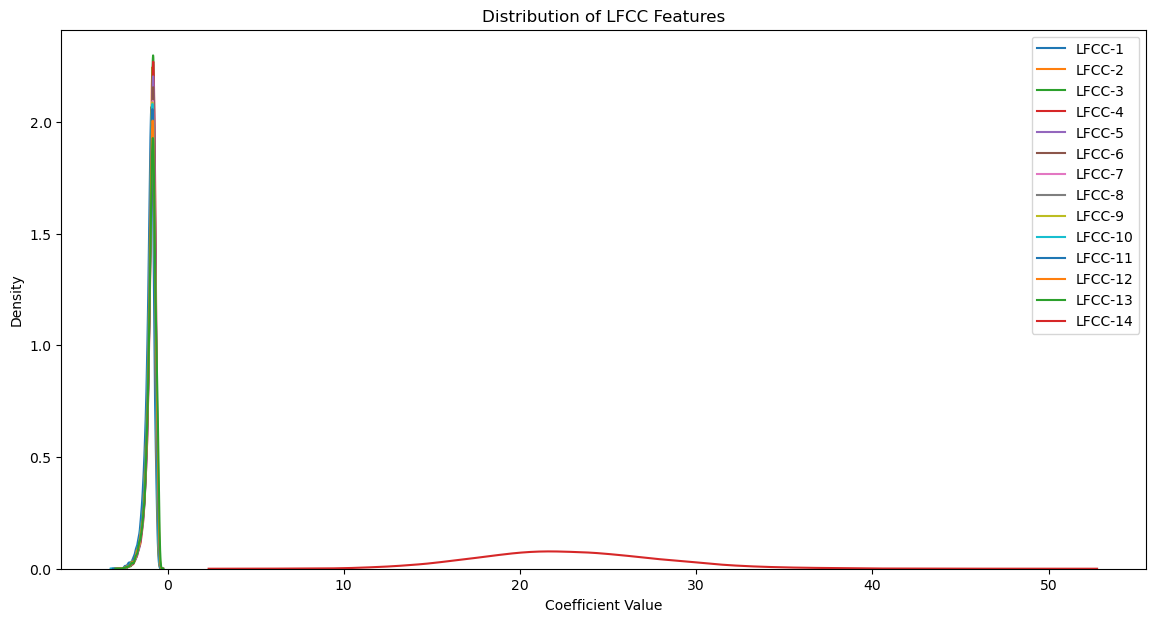

c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

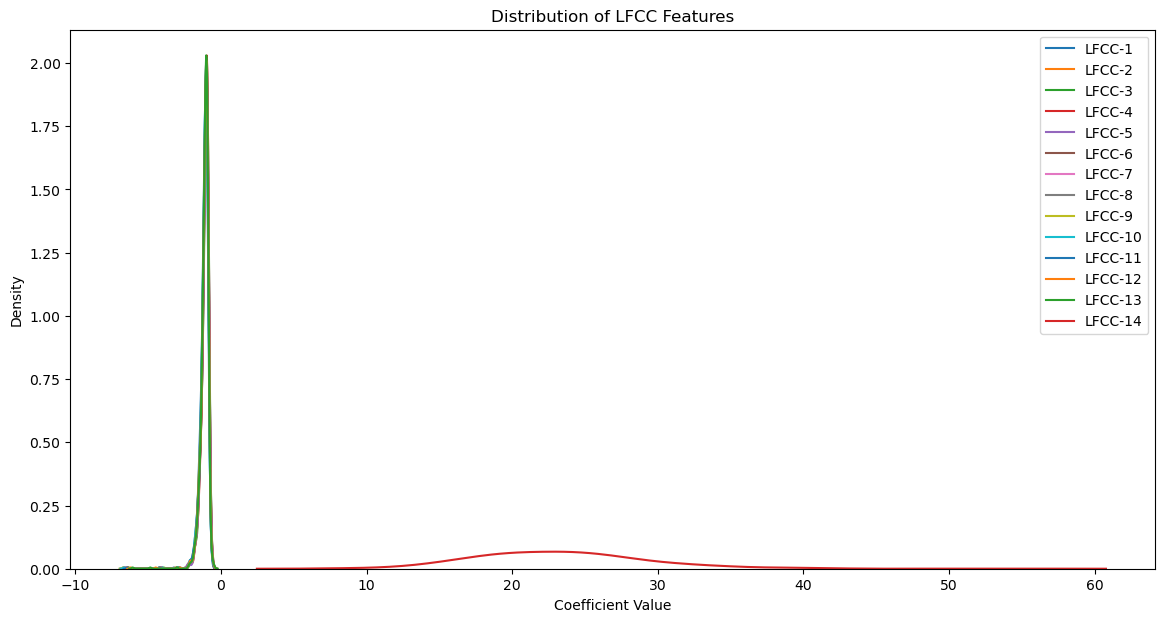

In [50]:
# Visualization Calls
plot_lfcc_distributions(aggregated_features)
plot_lfcc_distributions(synthetic_aggregated_features)

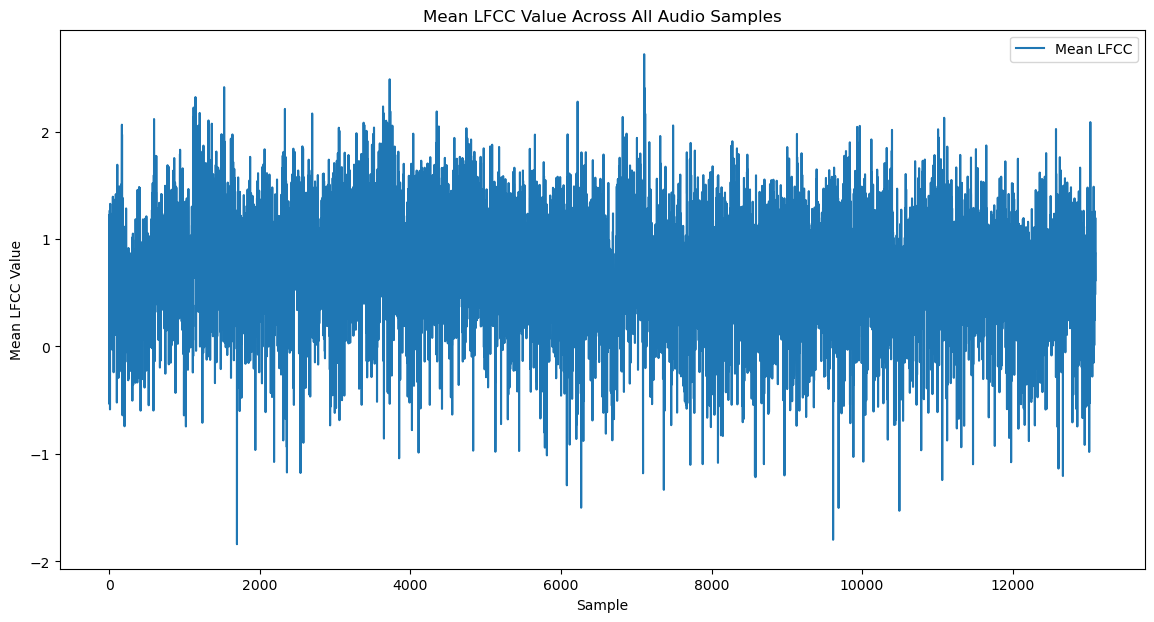

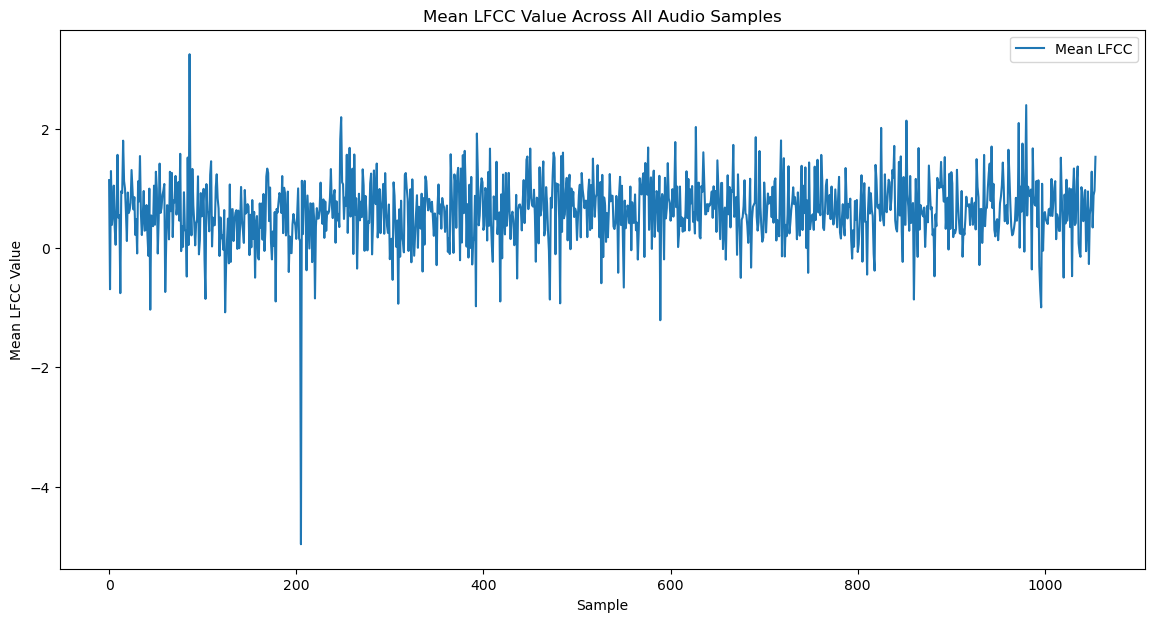

In [51]:
plot_mean_lfcc(aggregated_features)
plot_mean_lfcc(synthetic_aggregated_features)

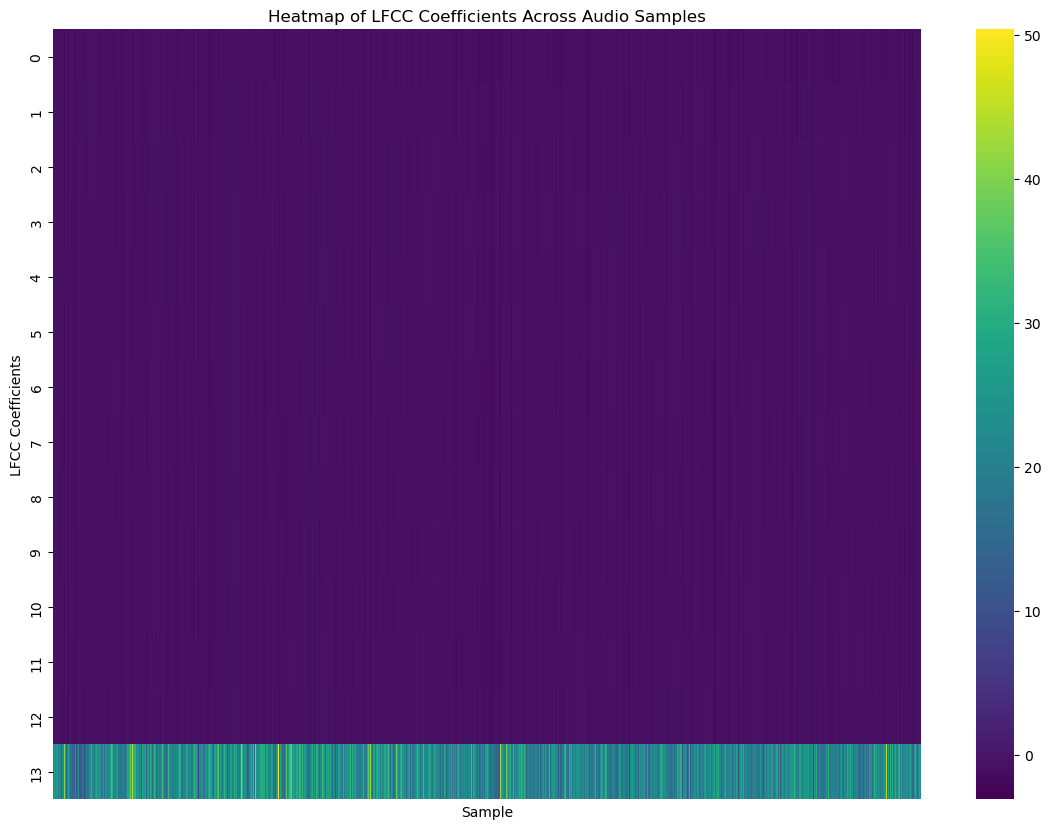

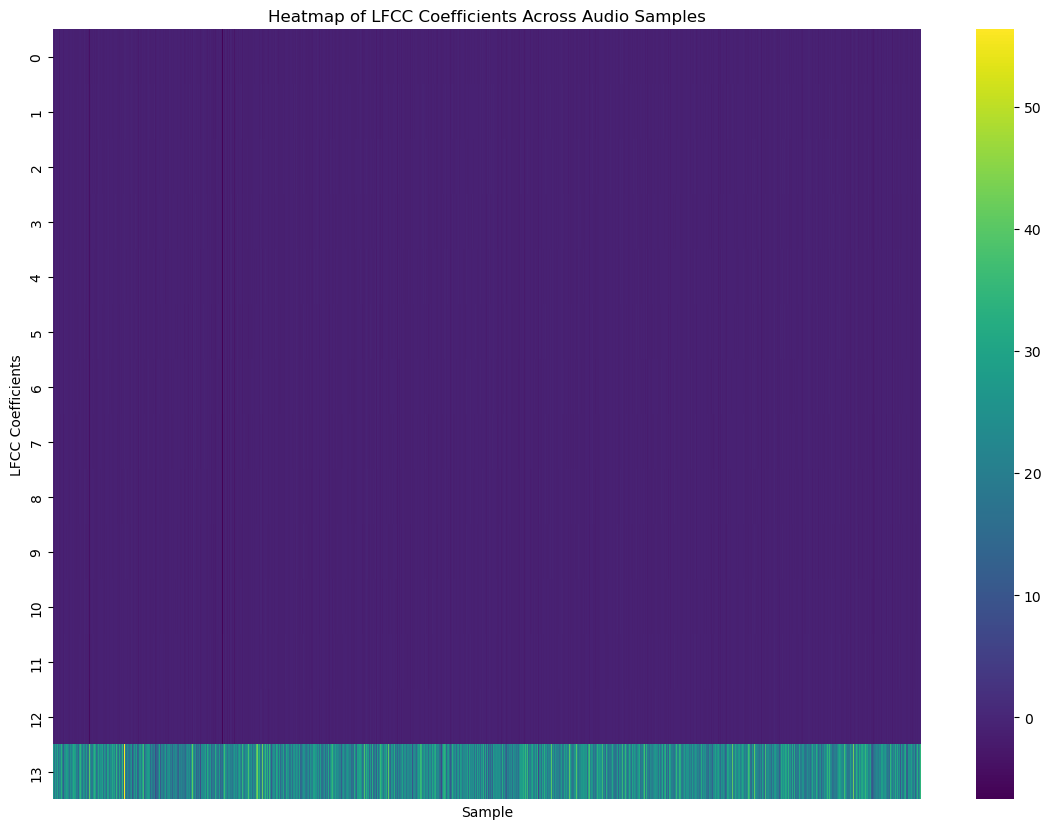

In [52]:
heatmap_lfcc_coefficients(aggregated_features)
heatmap_lfcc_coefficients(synthetic_aggregated_features)

Visualizing LFCC, Pitch, and Jitter

    LFCC Visualization: Given LFCC's importance in capturing the cepstral representation of audio, plotting the mean LFCC across all samples can offer insights into the spectral properties that differentiate human from synthetic voices.

    Pitch Visualization: Since pitch can be a distinguishing feature between human and synthetic voices, plotting the distribution of pitch values for each class can highlight differences in their modulation.

    Jitter Visualization: Jitter, which measures frequency variation, can also be visualized similarly to pitch. A comparison between human and synthetic audio can reveal nuances in voice stability.

Function Definitions for Feature Visualizations

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distribution(features, labels, feature_name):
    """
    Plot the distribution of a given feature for both real and synthetic audio samples.

    Args:
    - features: Numpy array of features.
    - labels: Array of labels (0 for synthetic, 1 for real).
    - feature_name: Name of the feature for labeling the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.distplot(features[labels == 1], bins=30, label='Real', color='blue')
    sns.distplot(features[labels == 0], bins=30, label='Synthetic', color='red')
    plt.legend()
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.show()

def plot_lfcc_features(lfcc_features, labels):
    """
    Plot the mean LFCC features for real and synthetic audio samples.
    
    Args:
    - lfcc_features: Numpy array of LFCC features.
    - labels: Array of labels (0 for synthetic, 1 for real).
    """
    mean_lfcc_real = np.mean(lfcc_features[labels == 1], axis=0)
    mean_lfcc_synthetic = np.mean(lfcc_features[labels == 0], axis=0)
    plt.figure(figsize=(14, 6))
    plt.plot(mean_lfcc_real, label='Real', color='blue')
    plt.plot(mean_lfcc_synthetic, label='Synthetic', color='red')
    plt.title('Mean LFCC Comparison')
    plt.xlabel('Coefficients')
    plt.ylabel('Mean Amplitude')
    plt.legend()
    plt.show()


Evaluating Model Performance

For model performance, beyond the traditional accuracy, precision, recall, and F1 scores, Equal Error Rate (EER) and Receiver Operating Characteristic (ROC) curves are especially useful in binary classification tasks like this.

    ROC Curve: Useful for visualizing the trade-off between the true positive rate and false positive rate at various thresholds.

    EER: This is where the false positive rate equals the false negative rate. It provides a single metric to evaluate the threshold-independent performance of the classifier.

In [55]:
def plot_roc_curve(true_labels, y_scores):
    """
    Plot the ROC curve for the model.
    
    Args:
    - true_labels: Ground truth binary labels.
    - y_scores: Predicted scores or probabilities from the model.
    """
    fpr, tpr, _ = roc_curve(true_labels, y_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def compute_and_plot_eer(y_true, y_scores):
    """
    Compute and plot the point on the ROC curve where the FPR equals the FNR (EER).
    
    Args:
    - y_true: Ground truth binary labels.
    - y_scores: Predicted scores or probabilities from the model.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([eer], [1-eer], marker='o', markersize=5, color="red", label='EER')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic with EER')
    plt.legend(loc="lower right")
    plt.show()
    return eer


**Model Training**
Gaussian Mixture Model (GMM): Train two GMMs for each dataset - one for the real audio distribution (using the original LJSPEECH dataset) and one for the generated audio samples. This step involves:
    Calculating the likelihood ratio for classifying samples.
    Using MFCC and LFCC features as inputs.
    
RawNet2 Training (Optional): As an alternative to GMM, train a CNN-GRU hybrid model known as RawNet2 which directly extracts features from raw audio to create embeddings for classification.

In [53]:

# Assuming you have a way to separate real and synthetic samples along with labels
# real_features, synthetic_features, real_labels, synthetic_labels = your_data_separation_method(features)

# Step 4: Train GMM Models
real_gmm = train_gmm(real_features_flat)
synthetic_gmm = train_gmm(synthetic_features_flat)

c:\Users\Outrun\anaconda3\envs\botCave\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [ ]:
plot_feature_distribution(real_features[:,0], labels, 'Pitch')
plot_lfcc_features(lfcc_features, labels)

In [ ]:


# Evaluate Models
# Assuming you have split your dataset into training and testing

# NOT DONE Still need to edit the evaluate function based on both labeled and unlabeled datasets
compute_eer_brentq()
EER, eer_threshold = evaluate_gmm(real_gmm, synthetic_gmm, test_features, true_labels)

print(f"EER: {EER}, Threshold: {eer_threshold}")


**Additional Considerations**
**Temporal and Behavioral Analysis**

Examine the timing and interaction patterns:

    Turn-Taking Patterns: Analyze the naturalness of conversation turns. Bot-generated speech might not follow typical human turn-taking behaviors.
    Response Latency: The time delay between conversation turns can also be a tell-tale sign. Bots might have consistent or unnatural response times.

**Synthetic Signature Identification**

Look for digital artifacts or signatures left by synthetic voice generation tools:

    Subtle Background Noises: Some voice synthesis tools leave specific types of background noise.
    Spectral Irregularities: Analyze the spectral footprint for any anomalies that would not occur in natural human speech.

**Afterward**

Implementing the above steps requires a blend of audio processing libraries (like LibROSA for Python), machine learning frameworks (such as TensorFlow or PyTorch), and possibly custom algorithms for detecting specific synthetic speech characteristics.

This expedition demands not just technical prowess but also a deep understanding of both human speech nuances and the capabilities of current audio generation technologies. Successfully navigating this will allow us to identify and analyze bot-generated audio with precision and discernment.

May your code run error-free, and may you find the signs you seek in the sea of digital voices.